<a href="https://colab.research.google.com/github/hudaor/leaf-disease-1/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
from PIL import Image
import itertools

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50, VGG19,InceptionV3
from tensorflow.keras.losses import categorical_crossentropy

In [ ]:
!pip install frimcla
!pip install mahotas 

!pip install -U numpy


In [ ]:
#print(length("/content/drive/MyDrive/2022dataset 05 2 22/train"))
#with open("/content/drive/MyDrive/2022dataset 05 2 22/train","r") as f:
    #print(len(f.readlines())) 


In [ ]:
# "drive/My Drive/Dataset/PlantVillage/"

#dir_list = [
     #"/content/drive/MyDrive/2022dataset 05 2 22/train/Diseased",
   #"/content/drive/MyDrive/2022dataset 05 2 22/train/Healthy"]
  
   # /content/drive/MyDrive/2022dataset 05 2 22/train/Healthy "drive/My Drive/Colab Notebooks/Base/Apple_Early_Stage/*.jpg",
    # "drive/My Drive/Colab Notebooks/Base/Apple_Middle_Stage/*.jpg",
    # "drive/My Drive/Colab Notebooks/Base/Apple_End_Stage/*.jpg"
# ]
#import os

#import glob
#import cv2

#dir_list = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/2022dataset 05 2 22/train/Healthy/1/*.jpg")] 
#print(dir_list)
   


In [ ]:
#dir_list[1] = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/2022dataset 05 2 22/train/Diseased/*.jpg")] 
            

dir_list = [
    "/content/drive/MyDrive/apple dataset inception/Apple Apple scab/*.JPG",
    "/content/drive/MyDrive/apple dataset inception/Apple Black rot/*.JPG",
     "/content/drive/MyDrive/apple dataset inception/Apple Cedar apple rust/*.JPG",
    "/content/drive/MyDrive/apple dataset inception/Apple Healthy/*.JPG"]


# = '/content/drive/MyDrive/2022dataset 05 2 22'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')

x = []
for directory in dir_list:
  for file in glob.glob(directory):
    m = np.array(Image.open(file))
    x.append(m)

#for directory in  dir_list[0]:
  #for file in glob.glob(directory):
    #m = np.array(Image.open(file))
    #x.append(m)

x = np.array(x)

print('x shape:', x.shape)

y = ['Apple Apple scab'] * len(glob.glob(dir_list[0]))
y += ['Apple Black rot'] * len(glob.glob(dir_list[1]))
y += ['Apple Cedar apple rust'] * len(glob.glob(dir_list[2]))
y += ['Apple Healthy'] * len(glob.glob(dir_list[3]))
y = np.array(y)
y = y.reshape(-1, 1)

print('y shape:', y.shape)    


x shape: (3171, 256, 256, 3)
y shape: (3171, 1)


In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

x_train_old, x_test_old, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=4, stratify=y)
print(x_train_old.shape)
print(x_test_old.shape)

del(x)
del(y)

(2536, 256, 256, 3)
(635, 256, 256, 3)


In [ ]:
lb = LabelBinarizer()

y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.fit_transform(y_test)

In [ ]:
%%time

x_train = []

for i in range(x_train_old.shape[0]):
    img = x_train_old[i]
    img = cv2.resize(img, dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
    x_train.append(np.concatenate((img, np.array(img_stack)),axis=2))

x_train = np.array(x_train)

x_train = x_train.astype('float32') / 255

CPU times: user 1min 47s, sys: 883 ms, total: 1min 48s
Wall time: 3.38 s


In [ ]:
%%time

x_test = []

for i in range(x_test_old.shape[0]):
    img = x_test_old[i]
    img = cv2.resize(img, dsize=(100,100))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(100,100,1))
    x_test.append(np.concatenate((img, np.array(img_stack)),axis=2))

x_test = np.array(x_test)

x_test = x_test.astype('float32') / 255

CPU times: user 26.5 s, sys: 197 ms, total: 26.6 s
Wall time: 816 ms


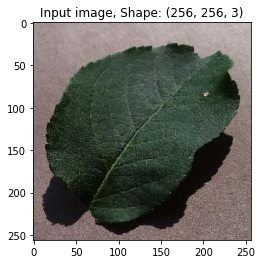

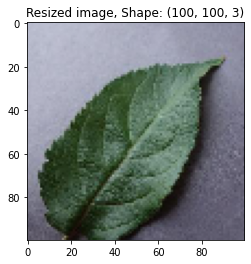

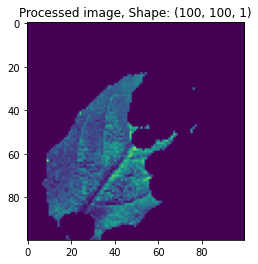

In [ ]:
Input_image = x_train_old[i+224]

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(100,100)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [ ]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (100, 100, 4)


In [ ]:
model = InceptionV3(weights=None, input_shape=x_train.shape[1:], classes=np.unique(y_train).shape[0])


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 4) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 49, 49, 32)   1152        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 49, 49, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 49, 49, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer = RMSprop(lr=.001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch, lr):
  return lr - 0.1 * lr if epoch % 100 == 0 else lr

learning_rate_scheduler = LearningRateScheduler(lr_scheduler, 
                                                verbose=1)

In [ ]:
datagen = ImageDataGenerator(rotation_range=40, 
                             zoom_range = 0.2, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             horizontal_flip=True, 
                             vertical_flip=True)

datagen.fit(x_train)

#for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=1):
    #plt.imshow(X_batch.reshape(100, 100, 4), cmap=plt.get_cmap('gray'))
    #plt.show()
    #break

In [ ]:
batch_size = 32
epochs = 50

In [ ]:
history = model.fit_generator(datagen.flow(x_train,
                                           y_train_bin, 
                                           batch_size=batch_size),
                              epochs = epochs,
                              steps_per_epoch=50,
                              verbose = 1,
                              validation_data = (x_test, y_test_bin))


#                               callbacks=[learning_rate_scheduler, early_stopping])

AttributeError: ignored

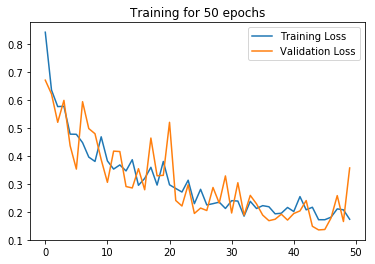

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

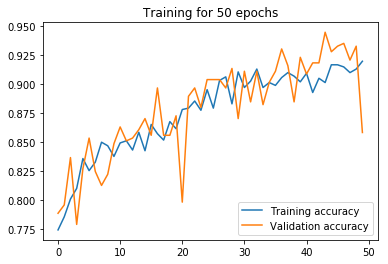

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [ ]:
print('Overall Accuracy on Test Set', np.mean(history.history['val_acc']))

Overall Accuracy on Test Set 0.8788968824940048


In [ ]:
print('Overall Accuracy on Train Set', np.mean(history.history['acc']))

Overall Accuracy on Train Set 0.8757863664552202


In [ ]:
model_feat = Model(inputs=model.input, outputs=model.layers[-4].output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(1667, 4608)
(417, 4608)


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')

svm.fit(feat_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
svm.score(feat_train, y_train)

0.9550089982003599

In [ ]:
svm.score(feat_test, y_test)

0.9496402877697842

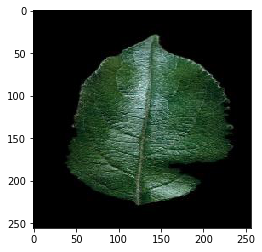

Real Label: Apple_Healthy
Predicted Label: Apple_Healthy


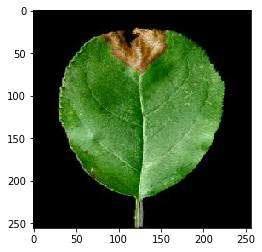

Real Label: Apple_Middle_Stage
Predicted Label: Apple_Middle_Stage


In [ ]:
test_data = 79

pred_label = svm.predict([feat_test[test_data]])

plt.imshow(x_test_old[test_data])
plt.show()

print('Real Label:', labelEncoder.inverse_transform([y_test[test_data]])[0])
print('Predicted Label:', labelEncoder.inverse_transform(pred_label)[0])

test_data = 405

pred_label = svm.predict([feat_test[test_data]])

plt.imshow(x_test_old[test_data])
plt.show()

print('Real Label:', labelEncoder.inverse_transform([y_test[test_data]])[0])
print('Predicted Label:', labelEncoder.inverse_transform(pred_label)[0])

In [ ]:
!pip3 install pandas_ml
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



     |████████████████████████████████| 102kB 3.3MB/s 


In [ ]:
from pandas_ml import ConfusionMatrix

y_pred = svm.predict(feat_test)
y_pred_orig = labelEncoder.inverse_transform(y_pred)
y_test_orig = labelEncoder.inverse_transform(y_test)
cm = ConfusionMatrix(y_test_orig, y_pred_orig)
print(cm)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Predicted           Apple_Early_Stage  Apple_End_Stage  Apple_Healthy  Apple_Middle_Stage  __all__
Actual                                                                                            
Apple_Early_Stage                  25                0              1                   1       27
Apple_End_Stage                     2               13              0                  10       25
Apple_Healthy                       1                0            328                   0      329
Apple_Middle_Stage                  1                5              0                  30       36
__all__                            29               18            329                  41      417
